In [1]:
import cython
import numpy as np
import sys
print(sys.path)
import CyRK
print(CyRK.__version__)

['N:\\Joe Documents\\Work Documents\\Software\\CyRK\\Tests', 'C:\\Users\\joepr\\anaconda3\\envs\\dev311\\python311.zip', 'C:\\Users\\joepr\\anaconda3\\envs\\dev311\\DLLs', 'C:\\Users\\joepr\\anaconda3\\envs\\dev311\\Lib', 'C:\\Users\\joepr\\anaconda3\\envs\\dev311', '', 'C:\\Users\\joepr\\anaconda3\\envs\\dev311\\Lib\\site-packages', 'C:\\Users\\joepr\\anaconda3\\envs\\dev311\\Lib\\site-packages\\win32', 'C:\\Users\\joepr\\anaconda3\\envs\\dev311\\Lib\\site-packages\\win32\\lib', 'C:\\Users\\joepr\\anaconda3\\envs\\dev311\\Lib\\site-packages\\Pythonwin']
0.10.0a3.dev12


In [2]:
import matplotlib.pyplot as plt
def diff_plot(t, y, fig_name=None):
    
    # Plot
    fig, ax = plt.subplots()
    ax.plot(t, y[0], 'r', label='$y_{0}$')
    ax.plot(t, y[1], 'b', label='$y_{1}$')
    ax.set(xlabel='$t$', ylabel='$y$')
    ax.legend(loc='best')
    
    # Show figure
    plt.show()
    
    # Save figure
    if fig_name is not None:
        fig.savefig(f'{fig_name}.pdf')

In [3]:
from CyRK.cy.cysolverX import pysolve_ivp

In [ ]:
t_start = 0.0
t_end = 50.0
y0 = np.asarray((20.0, 20.0), dtype=np.float64, order='C')

def diffeq(t, y):
    print("HEL")
    y0 = y[0]
    y1 = y[1]
    return [(1. - 0.01 * y1) * y0, (0.02 * y0 - 1.) * y1]

result = pysolve_ivp(
        diffeq,
        (t_start, t_end),
        y0,
        method = 'RK45',
        rtol = 1.0e-7,
        atol = 1.0e-8
        )

In [2]:
%load_ext cython

In [3]:
%%cython --annotate --force --compile-args=/openmp --link-args=/openmp -a
# distutils: language = c++
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False
import numpy as np

from libcpp cimport bool as cpp_bool
from CyRK.cy.pysolver import PySolverTest

t_start = 0.0
t_end = 50.0
y0 = np.asarray((20.0, 20.0), dtype=np.float64, order='C')

cdef size_t num_extra = 0
cdef cpp_bool capture_extra = False
cdef size_t expected_size = 300
cdef size_t max_num_steps = 100000
cdef size_t max_ram_MB = 2000

def run():
    test_inst = PySolverTest(t_start, t_end, y0, num_extra, capture_extra,
                         expected_size, max_num_steps, max_ram_MB)
    
    while test_inst.check_status():
        test_inst.take_step()
    test_inst.finalize()
    return test_inst

Content of stdout:
_cython_magic_3162ee415ca43536ab763145ee9ef327d022b1a6.cpp
LINK : warning LNK4044: unrecognized option '/openmp'; ignored
   Creating library C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_3162ee415ca43536ab763145ee9ef327d022b1a6.cp311-win_amd64.lib and object C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_3162ee415ca43536ab763145ee9ef327d022b1a6.cp311-win_amd64.exp
Generating code
Finished generating code

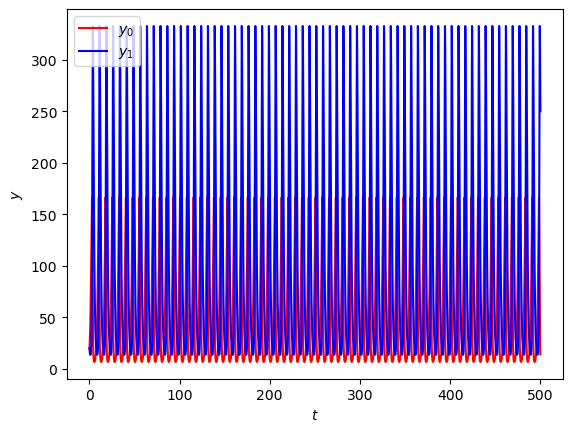

In [5]:
res = run()
diff_plot(res.t, res.y)

In [8]:
# 3.01ms; 3.08ms; 3.04ms
# Compared to pure C of 792us
%timeit run()

3.04 ms ± 67.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


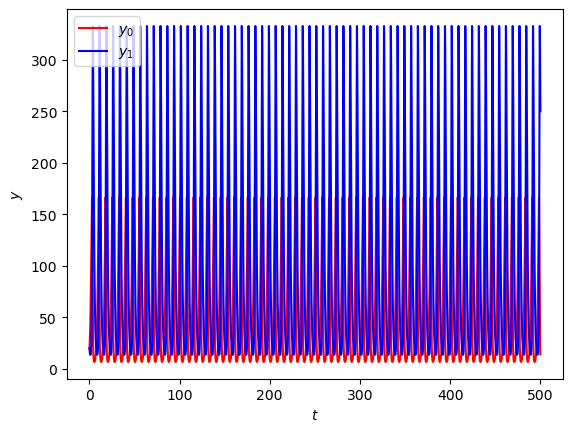

(2, 3535)


In [11]:
def diffeq(t, y):
    y0 = y[0]
    y1 = y[1]
    return [(1. - 0.01 * y1) * y0, (0.02 * y0 - 1.) * y1]

t_span = (0.0, 500.0)
rtol = 1.0e-7
atol = 1.0e-8
y0 = np.asarray((20.0, 20.0))

from scipy.integrate import solve_ivp

def run_sci():
    sol = solve_ivp(diffeq, t_span, y0, method='RK45', rtol=rtol, atol=atol)
    return sol

sol = run_sci()
diff_plot(sol.t, sol.y)
print(sol.y.shape)

In [12]:
%timeit run_sci()

407 ms ± 24.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
